# Deep Learning Text Search with Word2Vec, Doc2Vec, and LSTM

Esse notebook tem como principal objetivo descutir alguns problemas proposto a parti de abordagens de apresentadas no curso de Processamento de Linguagem Natural-PLN, ministrado pelo professor [Dr. Thales Vieira](https://ic.ufal.br/professor/thales/).

### Problemas propostos 
* Construção de um mecanismo de busca de palavras e documentos
* Desenvolvimento de algoritmos de similaridade semântica
* Classificação de documentos usando Doc2Vec
* Modelos baseados em LSTM para classificação
* Análise linguística e extração de informações com spaCy
* Tradução entre idiomas utilizando Seq2Seq

In [31]:
# Bibliotecas usadas
import os
import sys
import warnings
from collections import defaultdict, Counter
import ast
import gc


import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from tqdm import tqdm
import numpy as np


sys.path.append(os.path.abspath('..'))
warnings.filterwarnings('ignore')



nlp = spacy.load("en_core_web_sm")
bbc_clear = pd.read_csv("../data/bbc_clear_w2v_data_.csv")

## Preparação dos dados e vetorização 

In [ ]:
# Criar o diretório para salvar os vetores se ele não existir
os.makedirs("../data/vetores_np", exist_ok=True)

def preprocess(text: str) -> str:
    text = text.lower()
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)

def word2vec(text: str) -> np.ndarray:
    doc = nlp(text)
    return np.array([token.vector for token in doc])

def process_chunk(chunk, chunk_id):
    chunk["text_clean"] = chunk["data"].apply(preprocess)
    
    # Processar vetores e salvar em arquivos .npy
    # for idx, row in chunk.iterrows():
    #     vector = word2vec(row["text_clean"])
    #     np.save(f"../data/vetores_np/vector_{chunk_id}_{idx}.npy", vector)
    
    # Retornar apenas o texto limpo e o nome do arquivo do vetor
    chunk["vector_file"] = chunk.index.map(lambda x: f"vector_{chunk_id}_{x}.npy")
    return chunk[["text_clean", "vector_file"]]

chunksize = 10
reader = pd.read_csv("../data/bbc_data.csv", chunksize=chunksize)

for i, chunk in enumerate(tqdm(reader)):
    processed_chunk = process_chunk(chunk, i)
    
    mode = 'w' if i == 0 else 'a'
    header = i == 0
    
    processed_chunk.to_csv("../data/bbc_clear_w2v_data_.csv", mode=mode, index=False, header=header)
    
    # Limpar memória
    del processed_chunk
    gc.collect()

print("Processamento concluído. Os vetores foram salvos em /data/vetores_np/")

0it [00:00, ?it/s]

223it [05:04,  1.36s/it]

Processamento concluído. Os vetores foram salvos em /data/vetores_np/


## Implementação do Buscador de Palavras
Agora, vamos implementar um buscador de palavras similares usando os vetores do modelo e selecionar 5 palavras não existentes nos texto para encontrar cosrespondentes aparti da similaridade encontrada.

In [16]:
# Leitudara dos dados processados
bbc_clear = pd.read_csv("../data/bbc_clear_w2v_data_.csv")

def find_similar_words(word, docs, top_words = 3):
    word_vec = nlp(word).vector
    word_similarity = defaultdict(lambda: [0, ''])
    
    for idx, row in docs.iterrows():    
        vectors = np.load(f"../data/vetores_np/{row['vector_file']}")
        texts = row["text_clean"].split()
        for text, text_vec in zip(texts, vectors):
            similarity = np.dot(word_vec, text_vec) / (np.linalg.norm(word_vec) * np.linalg.norm(text_vec))
            if similarity > word_similarity[text][0]:
                word_similarity[text] = [similarity, row["vector_file"]]
    
    return sorted(
        [(word, sim[0], sim[1]) for word, sim in word_similarity.items()],
        key=lambda x: x[1],
        reverse=True
    )[:top_words]

# Palavras que acreditamos que não pertencem ao dataset
words_to_check = ["dateline","standfirst", "masthead","killfile", "shirttail"]

# Verificar se as palavras estão presentes no dataset
for to_check in words_to_check:
    for text in bbc_clear['text_clean']:
        if to_check in text:
            print(f"Palavra: {to_check}")
            break

# Verificar similaridade das palavras
for word in words_to_check:
    print(f"Palavra: {word}")
    print(find_similar_words(word, bbc_clear))
    print("\n")

Palavra: dateline
[('club', np.float32(0.6255402), 'vector_123_1234.npy'), ('race', np.float32(0.6107492), 'vector_137_1374.npy'), ('pocket', np.float32(0.61000097), 'vector_166_1662.npy')]


Palavra: standfirst
[('effectively', np.float32(0.55144566), 'vector_172_1722.npy'), ('deadly', np.float32(0.5470698), 'vector_204_2048.npy'), ('daily', np.float32(0.54395664), 'vector_0_6.npy')]


Palavra: masthead
[('geek', np.float32(0.6508971), 'vector_198_1985.npy'), ('company', np.float32(0.6476232), 'vector_32_320.npy'), ('deal', np.float32(0.64419633), 'vector_42_422.npy')]


Palavra: killfile
[('successful', np.float32(0.57894254), 'vector_112_1127.npy'), ('possible', np.float32(0.57717305), 'vector_114_1149.npy'), ('spurlock', np.float32(0.5759507), 'vector_37_371.npy')]


Palavra: shirttail
[('council', np.float32(0.7666771), 'vector_167_1674.npy'), ('liverpool', np.float32(0.74328095), 'vector_102_1024.npy'), ('stake', np.float32(0.7408067), 'vector_55_556.npy')]




### Análise dos resultados
Este relatório apresenta as três palavras mais similares encontradas para cada termo jornalístico específico, junto com suas pontuações de similaridade e arquivos de vetores correspondentes.

#### Dateline

| Palavra Similar | Pontuação de Similaridade | Arquivo de Vetor |
|-----------------|---------------------------|------------------|
| club            | 0.6255                    | vector_123_1234.npy |
| race            | 0.6107                    | vector_137_1374.npy |
| pocket          | 0.6100                    | vector_166_1662.npy |

Interpretação: As palavras mais similares a "dateline" parecem não ter uma relação direta com o termo jornalístico. Isso pode indicar que o termo "dateline" não está bem representado no conjunto de dados ou que o modelo tem dificuldade em capturar seu significado específico no contexto jornalístico.

#### Standfirst

| Palavra Similar | Pontuação de Similaridade | Arquivo de Vetor |
|-----------------|---------------------------|------------------|
| effectively     | 0.5514                    | vector_172_1722.npy |
| deadly          | 0.5471                    | vector_204_2048.npy |
| daily           | 0.5440                    | vector_0_6.npy      |

Interpretação: As palavras similares a "standfirst" também não parecem diretamente relacionadas ao termo jornalístico. A palavra "daily" pode ter alguma relação com jornalismo, mas as pontuações de similaridade são relativamente baixas.

#### Masthead

| Palavra Similar | Pontuação de Similaridade | Arquivo de Vetor |
|-----------------|---------------------------|------------------|
| geek            | 0.6509                    | vector_198_1985.npy |
| company         | 0.6476                    | vector_32_320.npy   |
| deal            | 0.6442                    | vector_42_422.npy   |

Interpretação: As palavras similares a "masthead" não parecem diretamente relacionadas ao termo jornalístico. "Company" pode ter alguma relação com organizações de mídia, mas a conexão não é forte.

#### Killfile

| Palavra Similar | Pontuação de Similaridade | Arquivo de Vetor |
|-----------------|---------------------------|------------------|
| successful      | 0.5789                    | vector_112_1127.npy |
| possible        | 0.5772                    | vector_114_1149.npy |
| spurlock        | 0.5760                    | vector_37_371.npy   |

Interpretação: As palavras similares a "killfile" não mostram uma relação clara com o termo jornalístico. As pontuações de similaridade são relativamente baixas.

#### Shirttail

| Palavra Similar | Pontuação de Similaridade | Arquivo de Vetor |
|-----------------|---------------------------|------------------|
| council         | 0.7667                    | vector_167_1674.npy |
| liverpool       | 0.7433                    | vector_102_1024.npy |
| stake           | 0.7408                    | vector_55_556.npy   |

Interpretação: As palavras similares a "shirttail" mostram as maiores pontuações de similaridade, mas não parecem diretamente relacionadas ao termo jornalístico. "Liverpool" pode se referir a notícias sobre a cidade ou o time de futebol.

#### Conclusão Geral

Os resultados sugerem que os termos jornalísticos específicos ("dateline", "standfirst", "masthead", "killfile", "shirttail") podem não estar bem representados no conjunto de dados ou no modelo de palavra. As palavras similares encontradas geralmente não têm uma relação clara com esses termos técnicos de jornalismo.

### Extendendo Buscador de Palavras
Complementando a analize de similaridade de palavras, vamos criar um novo campo de pontuações de similaridade para calcular, dodo uma palavra w qualquer, a media das similaridade entre as das 10 palavras mais proximas a w.

In [6]:
def calculate_average_distance(word, text, vector_file, top_words = 10):
    
    word_vec = nlp(word).vector
    word_similarity = {}
    
    vectors = np.load(f"../data/vetores_np/{vector_file}")
    words = text.split()
    for text, text_vec in zip(words, vectors):
        similarity = np.dot(word_vec, text_vec) / (np.linalg.norm(word_vec) * np.linalg.norm(text_vec))
        if text not in word_similarity or similarity > word_similarity[text]:
            word_similarity[text] = similarity
    
    top_similarity = sorted(
        word_similarity.values(),
        reverse=True
    )[:top_words]
    
    return np.mean(top_similarity)


def search_documents(word, df):
    df["D10"] = df.apply(lambda row: calculate_average_distance(word, row["text_clean"], row["vector_file"]), axis=1)
    return df.sort_values("D10").head(3)

def search_multiple_words(words, df):
    results = {}
    for word in words:
        results[word] = search_documents(word, df)
    return results

# Exemplo de uso
palavras_consulta = ["cycling", "technology", "economy", "science", "sports"]
resultados = search_multiple_words(palavras_consulta, bbc_clear)


### 


In [19]:
for i in resultados:
    print(f"Palavra: {i}")
    display(resultados[i])
    print("\n")

Palavra: cycling


,text_clean,vector_file,D10
983,ronaldo consider new contract manchester unite...,vector_98_983.npy,0.271326
938,capriati miss melbourne jennifer capriati lead...,vector_93_938.npy,0.272938
915,capriati australian open jennifer capriati lea...,vector_91_915.npy,0.273108




Palavra: technology


,text_clean,vector_file,D10
897,veteran martinez win thai title conchita marti...,vector_89_897.npy,0.291980
1117,robben play european return injure chelsea win...,vector_111_1117.npy,0.293687
902,pavey focus indoor success jo pavey miss janua...,vector_90_902.npy,0.297193




Palavra: economy


,text_clean,vector_file,D10
1305,iranian miss israel match iranian striker vahi...,vector_130_1305.npy,0.353963
1607,blunkett hint election ex home secretary david...,vector_160_1607.npy,0.359133
897,veteran martinez win thai title conchita marti...,vector_89_897.npy,0.368497




Palavra: science


,text_clean,vector_file,D10
476,latin america see strong growth latin america ...,vector_47_476.npy,0.308274
949,bosvelt optimistic new deal manchester citys p...,vector_94_949.npy,0.319522
1199,souness delight euro progress boss graeme soun...,vector_119_1199.npy,0.322392




Palavra: sports


,text_clean,vector_file,D10
1333,newcastle line babayaro newcastle manager grae...,vector_133_1333.npy,0.203704
1117,robben play european return injure chelsea win...,vector_111_1117.npy,0.210824
984,safin relieve aussie recovery marat safin admi...,vector_98_984.npy,0.212871


### Analize de resiltados

## Classificação de documentos usando Doc2Vec
De for analoda a realizada em [Text Classification](Text_Classification.ipynb), realizaresmo o trenamento dos seguintes modelos ultilizando Doc2Vec para gerar os embedings:
* Regreção Logistica
* SVM
* Naive Bayes

### Vetorização com Doc2Vec

In [20]:
# Preparar os documentos para o treinamento
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(bbc_clear['text_clean'])]

# Treinar o modelo Doc2Vec
doc2vec = Doc2Vec(
    documents,
    vector_size=100,
    window=5,
    min_count=2,
    dm=1,
    epochs=20,
    workers=4
)

# Função para gerar vetores
def get_vector(text):
    return doc2vec.infer_vector(text.split())

# Aplicar a função à coluna de texto e criar uma nova coluna
vectores_doc2vec = np.array(bbc_clear['text_clean'].apply(get_vector).to_list())

### Preparando os dados para o treinamento

In [22]:
# Dividir os dados em conjuntos de treinamento e teste na proproção 70/30
X = vectores_doc2vec
y = bbc_clear['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

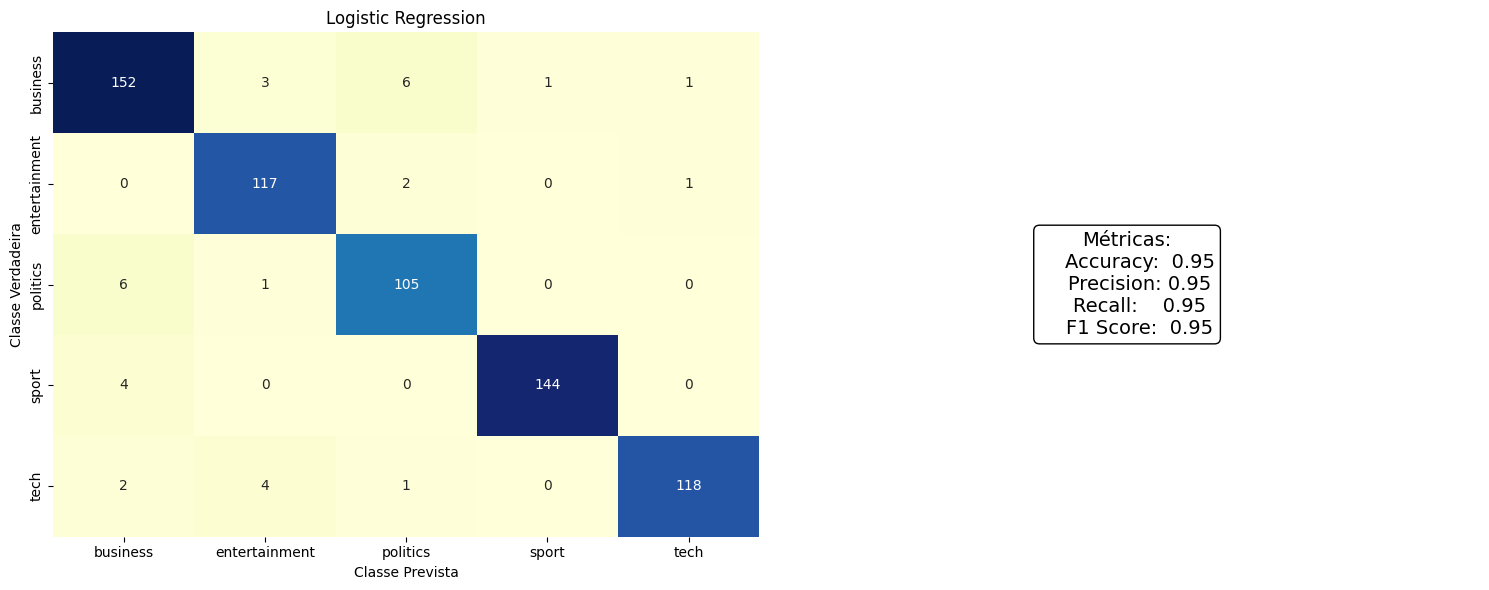

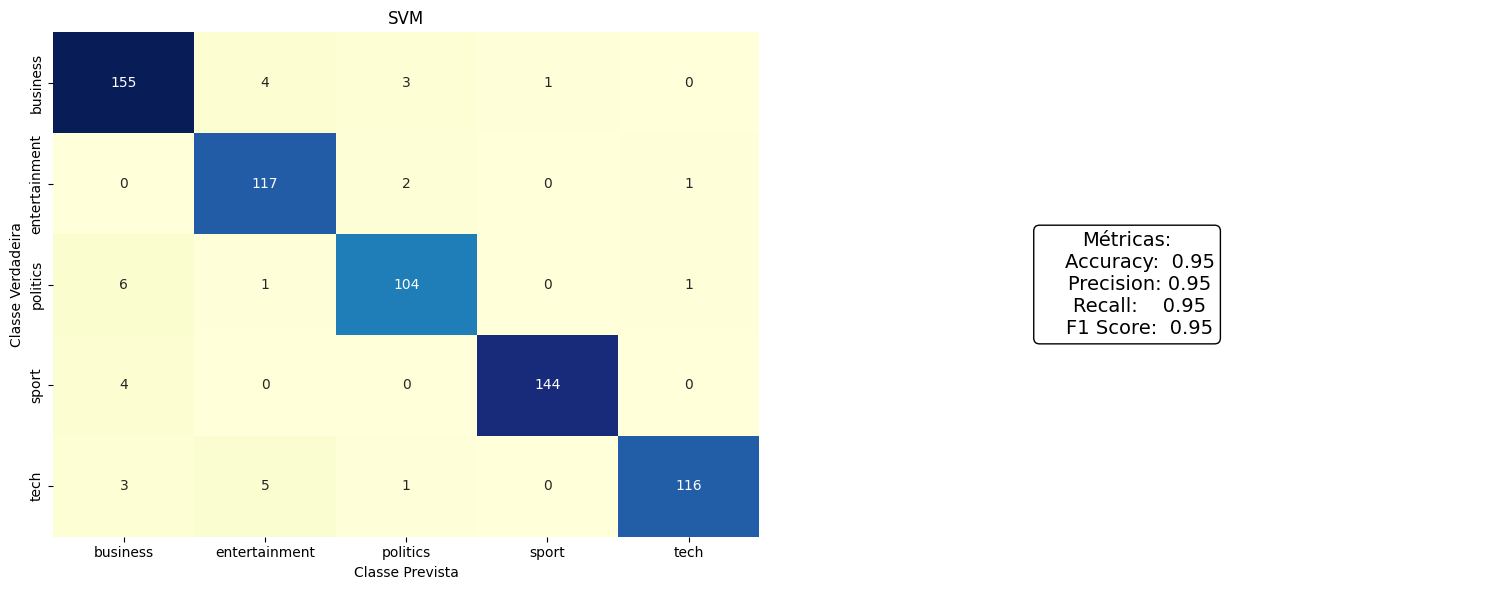

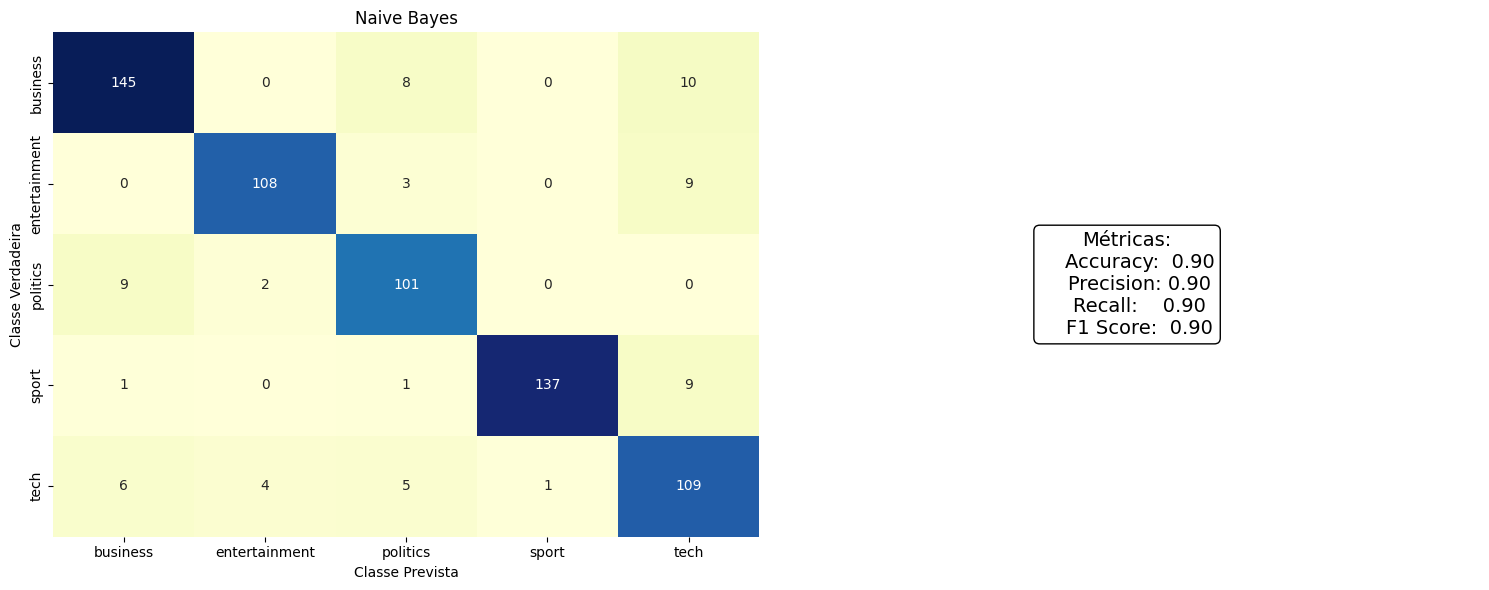

In [27]:
def metrics_describe(model, model_name):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # 1x2 grid
    
    # Classes
    classes = model.classes_
    
    # Matriz de Confusão
    sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=ax1, 
                xticklabels=classes, yticklabels=classes)
    ax1.set_title(f'{model_name}')
    ax1.set_xlabel('Classe Prevista')
    ax1.set_ylabel('Classe Verdadeira')
    
    # Métricas 
    metrics_text = f"""Métricas:
    Accuracy:  {accuracy:.2f}
    Precision: {precision:.2f}
    Recall:    {recall:.2f}
    F1 Score:  {f1:.2f}"""
    ax2.text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    ax2.axis('off')

    # Ajuste de layout
    plt.tight_layout()
    plt.show()

# O resto do código permanece o mesmo
def run_models():
    classifiers = {
        "Logistic Regression": LogisticRegression(),
        "SVM": LinearSVC(),
        "Naive Bayes": GaussianNB()
    }

    for model_name, model in classifiers.items():
        model.fit(X_train, y_train)
        metrics_describe(model, model_name)

# Chamando a função para rodar os modelos
run_models()

### Comparação de resultado
Tendo em vista que a proposta do Doc3Vec é justamente e um pouco além do que é feito pelo TF-IDF e Bag of Words, esperava se que o resultados obtidos por ele fossem os melhores, entretando temos levar em consideração que a quantidade de dados utilizadas para treinar nosso modelo foi relativamente pequena o que pode ter levado a generalização não tão boa dele.

| Modelo         | Representação | Accuracy | Precision | Recall | F1 Score |
|----------------|---------------|----------|-----------|--------|----------|
| Logistic Regression | Bag of Words | 0.97     | 0.97      | 0.97   | 0.97 |
|                | TF-IDF        | 0.98     | 0.98      | 0.98   | 0.98     |
|                | Doc2Vec       | 0.95     | 0.95      | 0.95   | 0.95     |
| SVM            | Bag of Words  | 0.98     | 0.98      | 0.98   | 0.98     |
|                | TF-IDF        | 0.98     | 0.98      | 0.98   | 0.98     |
|                | Doc2Vec       | 0.95     | 0.95      | 0.95   | 0.95     |
| Naive Bayes    | Bag of Words  | 0.98     | 0.98      | 0.98   | 0.98     |
|                | TF-IDF        | 0.97     | 0.97      | 0.97   | 0.97     |
|                | Doc2Vec       | 0.90     | 0.90      | 0.90   | 0.90     |





### LSTM



In [37]:
# Passo 1: Tokenização
max_words = 10000  # Número máximo de palavras a considerar
max_length = 200   # Comprimento máximo de cada sequência

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X = bbc_clear['text_clean']

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Passo 2: Padding
X_padded = pad_sequences(sequences, maxlen=max_length)

# Passo 3: Conversão de rótulos para formato one-hot
num_classes = len(label_encoder.classes_)
y_categorical = to_categorical(y_encoded, num_classes)
# Passo 4: Definição do modelo
embedding_dim = 100  # Dimensionalidade dos vetores de embedding

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length),
    LSTM(units=64, return_sequences=False),
    Dense(units=num_classes, activation='softmax')
])

# Passo 5: Compilação do modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Passo 6: Treinamento
model.fit(X_padded, y_categorical, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.2946 - loss: 1.4947 - val_accuracy: 0.0135 - val_loss: 3.9788
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.8576 - loss: 0.6331 - val_accuracy: 0.0899 - val_loss: 4.3414
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9828 - loss: 0.1264 - val_accuracy: 0.0966 - val_loss: 4.7571
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.9944 - loss: 0.0398 - val_accuracy: 0.0944 - val_loss: 5.6825
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.9979 - loss: 0.0194 - val_accuracy: 0.0989 - val_loss: 5.9491
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.9999 - loss: 0.0103 - val_accuracy: 0.0989 - val_loss: 6.3347
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.0989 - val_loss: 6.7645
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0

## Análise linguística e extração de informações com spaCy

In [9]:
# Extração das tags
def extract_pos_tags(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]

bbc_clear['pos_tags'] = bbc_clear['text_clean'].apply(extract_pos_tags)
bbc_clear

,labels,text_clean,vector_file,doc2vec,pos_tags,entities
0,entertainment,musician tackle red tape musician group tackle...,vector_0_0.npy,[ 1.1362157 -0.07267588 -0.5828703 -0.104504...,"[PROPN, VERB, ADJ, NOUN, NOUN, PROPN, PROPN, P...","{'persons': ['nigel mccune', 'james seller'], ..."
1,entertainment,desire number win prestigious grammy award hit...,vector_0_1.npy,[ 0.20397134 0.55562264 -1.3228865 -0.766386...,"[NOUN, NOUN, VERB, ADJ, PROPN, PROPN, VERB, NO...","{'persons': ['larry mullen jr echo', 'paul ree..."
2,entertainment,rocker doherty stage fight rock singer pete do...,vector_0_2.npy,[-0.2848767 -0.32057175 0.2144857 -0.848249...,"[PROPN, PROPN, NOUN, NOUN, NOUN, NOUN, PROPN, ...","{'persons': ['patrick walden', 'brixton', 'max..."
3,entertainment,snicket top box office chart film adaptation l...,vector_0_3.npy,[-0.08946598 -0.22915076 -0.13955405 -0.976793...,"[NOUN, PROPN, PROPN, PROPN, NOUN, NOUN, NOUN, ...","{'persons': ['jim carrey', 'daniel handler'], ..."
4,entertainment,ocean raid box office ocean crime caper sequel...,vector_0_4.npy,[ 0.7602021 0.8218042 0.26027724 -0.925180...,"[PROPN, PROPN, PROPN, PROPN, PROPN, NOUN, PROP...","{'persons': ['george clooney', 'tom hank festi..."
...,...,...,...,...,...,...
2220,tech,warn window word file write microsoft word doc...,vector_222_2220.npy,[ 0.727894 1.7202283 1.0201588 -1.075864...,"[VERB, NOUN, NOUN, NOUN, VERB, PROPN, NOUN, NO...","{'persons': ['andrew pearson european'], 'plac..."
2221,tech,fast lift rise record book high speed lift wor...,vector_222_2221.npy,[ 1.9478533 0.77215916 0.8470874 -1.048548...,"[ADJ, NOUN, NOUN, NOUN, NOUN, ADJ, NOUN, NOUN,...","{'persons': ['manufacturer toshiba', 'tall pet..."
2222,tech,nintendo add medium play ds nintendo release a...,vector_222_2222.npy,[ 0.05989644 -0.49967882 0.34440815 -0.955607...,"[PROPN, VERB, NOUN, NOUN, PROPN, ADJ, PROPN, P...","{'persons': ['gameboy'], 'places': []}"
2223,tech,fast move phone virus appear security firm war...,vector_222_2223.npy,[ 0.64316773 0.12719765 0.83465236 -1.375111...,"[ADJ, NOUN, NOUN, NOUN, VERB, NOUN, NOUN, VERB...","{'persons': [], 'places': []}"


### Cálculo e plotagem das frequências de cada tipo gramatical

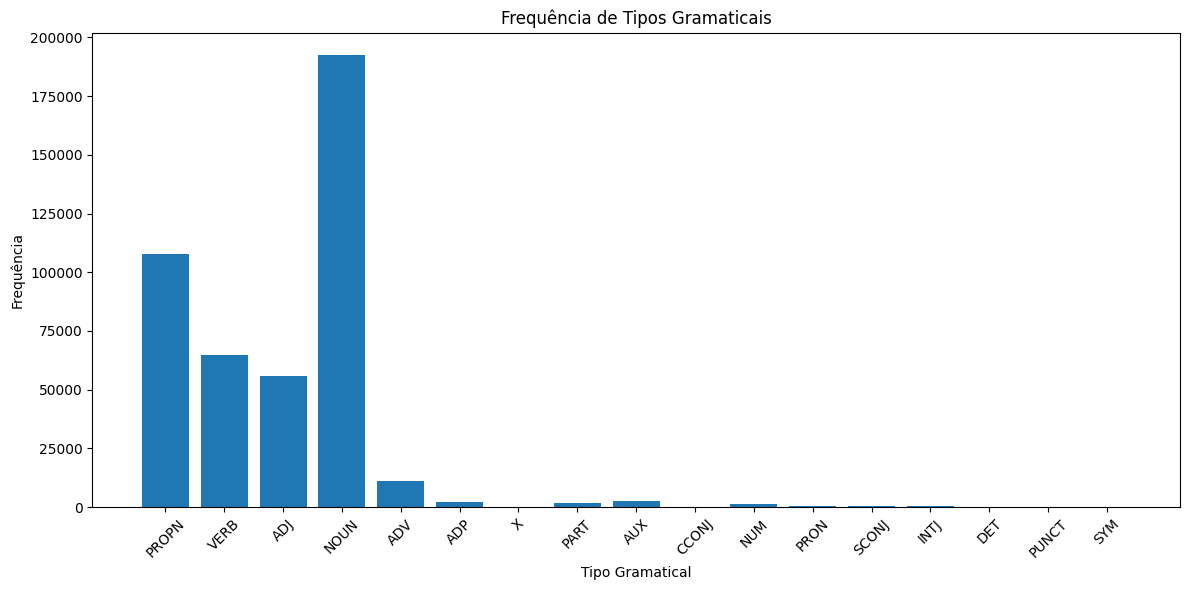

In [5]:
# Contagem das etiquetas POS
pos_counts = Counter([pos for tags in bbc_clear['pos_tags'] for pos in tags])

# Criando o gráfico
plt.figure(figsize=(12, 6))
plt.bar(pos_counts.keys(), pos_counts.values())
plt.title('Frequência de Tipos Gramaticais')
plt.xlabel('Tipo Gramatical')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Extração de entidades do tipo pessoa e lugar dos textos

In [10]:
def extract_entities(text):
    doc = nlp(text)
    persons = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    places = [ent.text for ent in doc.ents if ent.label_ == "LOC"]
    return {"persons": persons, "places": places}

bbc_clear['entities'] = bbc_clear['text_clean'].apply(extract_entities)
bbc_clear

,labels,text_clean,vector_file,doc2vec,pos_tags,entities
0,entertainment,musician tackle red tape musician group tackle...,vector_0_0.npy,[ 1.1362157 -0.07267588 -0.5828703 -0.104504...,"[PROPN, VERB, ADJ, NOUN, NOUN, PROPN, PROPN, P...","{'persons': ['nigel mccune', 'james seller'], ..."
1,entertainment,desire number win prestigious grammy award hit...,vector_0_1.npy,[ 0.20397134 0.55562264 -1.3228865 -0.766386...,"[NOUN, NOUN, VERB, ADJ, PROPN, PROPN, VERB, NO...","{'persons': ['larry mullen jr echo', 'paul ree..."
2,entertainment,rocker doherty stage fight rock singer pete do...,vector_0_2.npy,[-0.2848767 -0.32057175 0.2144857 -0.848249...,"[PROPN, PROPN, NOUN, NOUN, NOUN, NOUN, PROPN, ...","{'persons': ['patrick walden', 'brixton', 'max..."
3,entertainment,snicket top box office chart film adaptation l...,vector_0_3.npy,[-0.08946598 -0.22915076 -0.13955405 -0.976793...,"[NOUN, PROPN, PROPN, PROPN, NOUN, NOUN, NOUN, ...","{'persons': ['jim carrey', 'daniel handler'], ..."
4,entertainment,ocean raid box office ocean crime caper sequel...,vector_0_4.npy,[ 0.7602021 0.8218042 0.26027724 -0.925180...,"[PROPN, PROPN, PROPN, PROPN, PROPN, NOUN, PROP...","{'persons': ['george clooney', 'tom hank festi..."
...,...,...,...,...,...,...
2220,tech,warn window word file write microsoft word doc...,vector_222_2220.npy,[ 0.727894 1.7202283 1.0201588 -1.075864...,"[VERB, NOUN, NOUN, NOUN, VERB, PROPN, NOUN, NO...","{'persons': ['andrew pearson european'], 'plac..."
2221,tech,fast lift rise record book high speed lift wor...,vector_222_2221.npy,[ 1.9478533 0.77215916 0.8470874 -1.048548...,"[ADJ, NOUN, NOUN, NOUN, NOUN, ADJ, NOUN, NOUN,...","{'persons': ['manufacturer toshiba', 'tall pet..."
2222,tech,nintendo add medium play ds nintendo release a...,vector_222_2222.npy,[ 0.05989644 -0.49967882 0.34440815 -0.955607...,"[PROPN, VERB, NOUN, NOUN, PROPN, ADJ, PROPN, P...","{'persons': ['gameboy'], 'places': []}"
2223,tech,fast move phone virus appear security firm war...,vector_222_2223.npy,[ 0.64316773 0.12719765 0.83465236 -1.375111...,"[ADJ, NOUN, NOUN, NOUN, VERB, NOUN, NOUN, VERB...","{'persons': [], 'places': []}"


### Identificação e listagem das pessoas mais frequentes nos textos

In [8]:
person_counts = Counter()

for entities in bbc_clear['entities']:
    unique_persons = set(entities['persons'])
    person_counts.update(unique_persons)

# Mostrando as 10 pessoas mais frequentes
print("As 10 pessoas mais frequentes nos textos:")
for person, count in person_counts.most_common(10):
    print(f"{person}: {count}")

As 10 pessoas mais frequentes nos textos:
tony blair: 107
michael howard: 85
blair: 67
gordon brown: 63
lib dem: 57
eu: 53
charles kennedy: 46
bush: 36
williams: 34
alan milburn: 29


## Tradução entre idiomas utilizando Seq2Seq

In [27]:
#Configurações
batch_size = 64 # Tamanho do lote
epochs = 10 # Número de épocas
latent_dim = 256 # Dimensão latente
num_sample = 10000 # Número de amostras

# Carregar os dados
with open("../data/eng-por.txt", "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
lines[:5]

['Go.\tVai.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1196331 (alexmarcelo)',
 'Go.\tVá.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5464111 (ToinhoAlam)',
 'Hi.\tOi.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #397074 (brauliobezerra)',
 'Run!\tCorre!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1197457 (alexmarcelo)',
 'Run!\tCorra!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1197458 (alexmarcelo)']

### Preparação e Processamento
Lê os pares de textos de entrada e saída, mapeia cada caractere único, e transforma tudo em matrizes numéricas usando one-hot encoding. Também adiciono marcadores especiais (\t e \n) para sinalizar início e fim das frases, e faço o padding para todas as sequências terem o mesmo tamanho. 

In [40]:
input_texts = []
target_texts = []
input_charactars = set()
target_charactars = set()

for line in lines[:min(num_sample, len(lines)-1)]:
    input_text, target_text, _ = line.split("\t")
    # Para sinalizar o inicio e fim de uma linha, colocamos "\t" e "\n" respectivamente
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_charactars:
            input_charactars.add(char)
    for char in target_text:
        if char not in target_charactars:    
            target_charactars.add(char)
            
input_charactars = sorted(list(input_charactars))
target_charactars = sorted(list(target_charactars))
num_encoder_tokens = len(input_charactars)
num_decoder_tokens = len(target_charactars)
max_encoder_seq_lenght = max([len(txt) for txt in input_texts])
max_decoder_seq_lenght = max([len(txt) for txt in target_texts])

print("Numero de sequencias de treinamento: ", len(input_texts))
print("Numero de tokens de entrada: ", num_encoder_tokens)
print("Numero de tokens de saida: ", num_decoder_tokens)
print("Tamanho maximo da sequencia de entrada: ", max_encoder_seq_lenght)
print("Tamanho maximo da sequencia de saida: ", max_decoder_seq_lenght)

input_token_index = dict([(char, i) for i, char in enumerate(input_charactars)])
target_token_index = dict([(char, i) for i, char in enumerate(target_charactars)])

# Vetores tridimensionais para armazenar os dados de entrada e saida
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_lenght, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_lenght, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_lenght, num_decoder_tokens), dtype="float32")

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Numero de sequencias de treinamento:  10000
Numero de tokens de entrada:  70
Numero de tokens de saida:  85
Tamanho maximo da sequencia de entrada:  15
Tamanho maximo da sequencia de saida:  45


### Construção e treinamento do modelo

In [41]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_input = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_input, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_input], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_split=0.2)

model.save("s2s_model.keras")

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.6555 - loss: 1.7377 - val_accuracy: 0.6595 - val_loss: 1.3560
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.7053 - loss: 1.1007 - val_accuracy: 0.6927 - val_loss: 1.1541
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.7343 - loss: 0.9759 - val_accuracy: 0.7135 - val_loss: 1.0439
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.7538 - loss: 0.8783 - val_accuracy: 0.7336 - val_loss: 0.9375
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.7729 - loss: 0.7918 - val_accuracy: 0.7429 - val_loss: 0.8760
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.7833 - loss: 0.7443 - val_accuracy: 0.7518 - val_loss: 0.8446
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.7930 - loss: 0.7048 - val_accuracy: 0.7641 - val_loss: 0.8142
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.7993 - loss: 0

In [42]:
model = load_model("s2s_model.keras")

encoder_inputs = model.input[0]  
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0


    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_lenght:
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]

for seq_index in range(20):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: None
-
Input sentence: Go.
Decoded sentence: None
-
Input sentence: Hi.
Decoded sentence: None
-
Input sentence: Run!
Decoded sentence: None
-
Input sentence: Run!
Decoded sentence: None
-
Input sentence: Run!
Decoded sentence: None
-
Input sentence: Run.
Decoded sentence: None
-
Input sentence: Run.
Decoded sentence: None
-
Input sentence: Run.
Decoded sentence: None
-
Input sentence: Who?
Decoded sentence: None
-
Input sentence: Who?
Decoded sentence: None
-
Input sentence: Wow!
Decoded sentence: None
-
Input sentence: Wow!
Decoded sentence: None
-
Input sentence: Wow!
Decoded sentence: None
-
Input sentence: Duck!
Decoded sentence: None
-
Input sentence: Fire!
Decoded sentence: None
-
Input sentence: Fire!
Decoded sentence: None
-
Input sentence: Fire!
Decoded sentence: None
-
Input sentence: Help!
Decoded sentence: None
-
Input sentence: Help!
Decoded sentence: None
